#### Import Modules

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py
import matplotlib.pyplot as plt

from tf_utils import load_dataset, convert_to_one_hot, random_mini_batches, predict
%matplotlib inline

import scipy
from PIL import Image
from scipy import ndimage
scipy.__version__

'1.1.0'

#### Data preparation

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)

(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)


y = 5


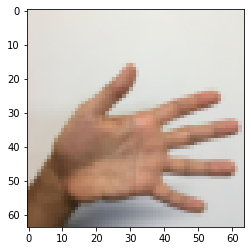

In [4]:
# visualize the picture
index = 0
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
# Flatten the dataset
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
print(X_train_flatten.shape)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
print(X_test_flatten.shape)

# Normalize the image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one-hot matrix
c = len(np.unique(Y_train_orig))
Y_train = convert_to_one_hot(Y_train_orig, c)
print(Y_train.shape)
Y_test = convert_to_one_hot(Y_test_orig, c)
print(Y_test.shape)

(12288, 1080)
(12288, 120)
(6, 1080)
(6, 120)


In [6]:
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


#### Create Placeholders

In [7]:
def create_placeholders(n_x, n_y):
    """
    Arguments:
    n_x -- scalar, size of an image vector (64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so n_y = 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    You will use None because it let's us be flexible on the number of examples you will for the placeholders.
    In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = 'Y')
    
    return X, Y

#### Initialize Parameters

In [8]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1" : W1,
                 "b1" : b1,
                 "W2" : W2,
                 "b2" : b2,
                 "W3" : W3,
                 "b3" : b3}
    return parameters

#### Forward Propagation

In [9]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

#### Compute Cost

In [10]:
def compute_cost(Z3, Y):
    """
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    
    """
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

#### The final model

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)            # to keep a consistent result
    seed = 3                         # to keep a consistent result, used in mini-batches
    (n_x, m) = X_train.shape         # n_x : input size (input features); m : num of examples in the train set
    n_y = Y_train.shape[0]           # n_y : num of classes
    costs = []
    
    # Create Placeholders
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize Parameters
    parameters = initialize_parameters()
    
    # Forward Propagation
    Z3 = forward_propagation(X, parameters)
    
    # Cost Function
    cost = compute_cost(Z3, Y)
    
    # Backpropagation using Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initialize all the variables
    init = tf.global_variables_initializer()
    
    # start the session and compute the tensorflow graph
    with tf.Session() as sess:
        # run the initialization
        sess.run(init)
        
        # do the training loop 
        for epoch in range(num_epochs):
            epoch_cost = 0.       # defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                # select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # optimization
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                # compute the epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                
            # print the cost
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # Plot the cost - 
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning Rate = " + str(learning_rate))
        plt.show()
        
        # saving parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained")
        
        # calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print("Train Accuracy: ", accuracy.eval({X : X_train, Y : Y_train}))
        print("Test Accuracy: ", accuracy.eval({X : X_test, Y : Y_test}))
        
        return parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.017255
Cost after epoch 200: 0.733184
Cost after epoch 300: 0.573071
Cost after epoch 400: 0.468573
Cost after epoch 500: 0.381228
Cost after epoch 600: 0.313815
Cost after epoch 700: 0.253708
Cost after epoch 800: 0.203900
Cost after epoch 900: 0.166454
Cost after epoch 1000: 0.146636
Cost after epoch 1100: 0.107279
Cost after epoch 1200: 0.086698
Cost after epoch 1300: 0.059342
Cost afte

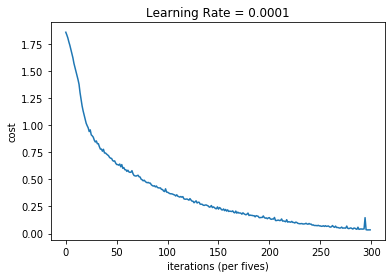

Parameters have been trained
Train Accuracy:  0.9990741
Test Accuracy:  0.725


In [12]:
parameters = model(X_train, Y_train, X_test, Y_test)

### Try your own image ###

In [ ]:
my_image = "two.jpg"
#Pre-process.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

C:\Users\Suvro\Anaconda_2020_3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\Suvro\Anaconda_2020_3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
